# 🎯 문단 레벨 반복 학습 (Max Pooling 버전)

## 핵심 아이디어

### Human 문서:
```
문단 1: 0.35 → Loss(0.35, 0) → 0으로 회귀
문단 2: 0.28 → Loss(0.28, 0) → 0으로 회귀
문단 3: 0.42 → Loss(0.42, 0) → 0으로 회귀
```
**각 문단이 0에 가까워지도록!**

### AI 문서:
```
문단 1: 0.75
문단 2: 0.82  } MAX = 0.82
문단 3: 0.68

→ 하나라도 높으면 AI로 판정!
```
**Max Pooling: 가장 높은 문단 점수로 문서 판정!**

## 변경사항 (vs 가중평균 버전)
- ✅ `np.average()` → `np.max()`
- ✅ `true_label` 사용 (버그 수정)
- ✅ AI 문서: 최고 점수 문단만 학습 (선택적)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q transformers datasets

In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import json
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트
!apt-get install -qq fonts-nanum
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device: {device}")

Selecting previously unselected package fonts-nanum.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
🖥️  Device: cuda


## ⚙️ 설정

In [19]:
BASE_PATH = '/content/drive/MyDrive/멋사_프로젝트_01/'
TRAIN_DATA_PATH = os.path.join(BASE_PATH, 'train.csv')
TEST_DATA_PATH = os.path.join(BASE_PATH, 'test.csv')
CHECKPOINT_DIR = os.path.join(BASE_PATH, 'checkpoints')
RESULTS_DIR = os.path.join(BASE_PATH, 'paragraph_maxpool_results')  # 변경!
os.makedirs(RESULTS_DIR, exist_ok=True)

# 하이퍼파라미터
MODEL_NAME = 'klue/bert-base'
MAX_LENGTH = 512
BATCH_SIZE = 16
SAMPLE_SIZE_PER_CLASS = 1000
MAX_ITERATIONS = 2
LEARNING_RATE = 2e-5
FINETUNE_EPOCHS = 1

# ⭐ Max Pooling 설정
AGGREGATION = 'max'  # 'max' or 'avg'

print(f"✅ 설정 완료")
print(f"  샘플: {SAMPLE_SIZE_PER_CLASS * 2}")
print(f"  Iterations: {MAX_ITERATIONS}")
print(f"  Aggregation: {AGGREGATION}")

✅ 설정 완료
  샘플: 2000
  Iterations: 2
  Aggregation: max


## 🤖 모델 정의

In [20]:
class BERTParagraphClassifier(nn.Module):
    def __init__(self, model_name, num_classes=2, dropout=0.1):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        cls_embedding = self.dropout(cls_embedding)
        logits = self.classifier(cls_embedding)
        return logits

class ParagraphDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.float)
        }

print("✅ 모델 정의 완료")

✅ 모델 정의 완료


## 📊 데이터 로드

In [21]:
df_train = pd.read_csv(TRAIN_DATA_PATH)

# Stratified Sampling
human_docs = df_train[df_train['generated'] == 0].sample(n=SAMPLE_SIZE_PER_CLASS, random_state=42)
ai_docs = df_train[df_train['generated'] == 1].sample(n=SAMPLE_SIZE_PER_CLASS, random_state=42)
balanced_df = pd.concat([human_docs, ai_docs]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✅ Balanced: {len(balanced_df)}")
print(balanced_df['generated'].value_counts())

✅ Balanced: 2000
generated
1    1000
0    1000
Name: count, dtype: int64


In [22]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = BERTParagraphClassifier(MODEL_NAME)
checkpoint = torch.load(f'{CHECKPOINT_DIR}/best_model.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

print(f"✅ Model loaded")

✅ Model loaded


## 🛠️ 핵심 함수 (Max Pooling 버전)

In [23]:
@torch.no_grad()
def predict_paragraph_scores(model, texts, tokenizer, device, batch_size=16):
    model.eval()
    all_scores = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        encodings = tokenizer(
            batch_texts,
            max_length=MAX_LENGTH,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = encodings['input_ids'].to(device)
        attention_mask = encodings['attention_mask'].to(device)

        logits = model(input_ids, attention_mask)
        probs = F.softmax(logits, dim=1)
        ai_scores = probs[:, 1].cpu().numpy()
        all_scores.extend(ai_scores)

    return np.array(all_scores)

def predict_documents(model, df, tokenizer, device, aggregation='max'):
    """
    문서 예측 (Max Pooling 또는 가중평균)

    aggregation: 'max' or 'avg'
    """
    results = []
    all_paragraph_data = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="예측"):
        doc_text = row['full_text']
        true_label = row['generated']

        paragraphs = [p.strip() for p in str(doc_text).split('\n') if p.strip()]
        if len(paragraphs) == 0:
            continue

        para_scores = predict_paragraph_scores(model, paragraphs, tokenizer, device, BATCH_SIZE)
        para_lengths = [len(p) for p in paragraphs]

        # ⭐ 집계 방식 선택
        if aggregation == 'max':
            doc_score = np.max(para_scores)  # Max Pooling!
            max_para_idx = np.argmax(para_scores)  # 가장 높은 문단 인덱스
        else:
            doc_score = np.average(para_scores, weights=para_lengths)  # 가중평균
            max_para_idx = -1

        predicted_label = 1 if doc_score > 0.5 else 0

        for para_idx, (para, score, length) in enumerate(zip(paragraphs, para_scores, para_lengths)):
            all_paragraph_data.append({
                'doc_idx': idx,
                'para_idx': para_idx,
                'paragraph': para,
                'ai_score': score,
                'length': length,
                'is_max': para_idx == max_para_idx  # 가장 높은 문단 표시
            })

        results.append({
            'doc_idx': idx,
            'doc_score': doc_score,  # max 또는 avg
            'predicted_label': predicted_label,
            'true_label': true_label,
            'num_paragraphs': len(paragraphs),
            'max_para_idx': max_para_idx
        })

    return pd.DataFrame(results), pd.DataFrame(all_paragraph_data)

print("✅ 예측 함수 완료 (Max Pooling 지원)")

✅ 예측 함수 완료 (Max Pooling 지원)


In [24]:
def create_training_data_paragraph_level(doc_predictions, paragraph_data, ai_strategy='all'):
    """
    🎯 핵심: 문단 레벨 학습 데이터 생성 (Ground Truth 기반)

    Human (true_label=0): 각 문단 → target 0
    AI (true_label=1):
        - ai_strategy='all': 모든 문단 → target 1
        - ai_strategy='max_only': 최고 점수 문단만 → target 1
    """
    train_data = []

    # 1️⃣ 실제 Human 문서 (true_label=0) → 각 문단 target=0
    human_docs = doc_predictions[doc_predictions['true_label'] == 0]['doc_idx'].tolist()
    human_paragraphs = paragraph_data[paragraph_data['doc_idx'].isin(human_docs)]

    for _, row in human_paragraphs.iterrows():
        train_data.append({
            'text': row['paragraph'],
            'target': 0.0,
            'type': 'human_para'
        })

    # 2️⃣ 실제 AI 문서 (true_label=1)
    ai_docs = doc_predictions[doc_predictions['true_label'] == 1]['doc_idx'].tolist()
    ai_paragraphs = paragraph_data[paragraph_data['doc_idx'].isin(ai_docs)]

    if ai_strategy == 'max_only':
        # 가장 높은 점수 문단만 학습
        ai_paragraphs = ai_paragraphs[ai_paragraphs['is_max'] == True]

    for _, row in ai_paragraphs.iterrows():
        train_data.append({
            'text': row['paragraph'],
            'target': 1.0,
            'type': 'ai_para'
        })

    df = pd.DataFrame(train_data)
    return df['text'].tolist(), df['target'].tolist()

print("✅ 학습 데이터 생성 함수 완료")

✅ 학습 데이터 생성 함수 완료


In [25]:
def finetune_paragraph_level(model, train_texts, train_targets, tokenizer, device, epochs=1):
    """
    문단 레벨 Fine-tuning
    """
    dataset = ParagraphDataset(train_texts, train_targets, tokenizer, MAX_LENGTH)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()

    model.train()
    total_loss = 0

    for epoch in range(epochs):
        epoch_loss = 0

        for batch in tqdm(loader, desc=f"Fine-tuning {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            optimizer.zero_grad()

            logits = model(input_ids, attention_mask)
            ai_logits = logits[:, 1]

            loss = criterion(ai_logits, targets)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(loader)
        print(f"  Epoch {epoch+1} Loss: {avg_loss:.4f}")
        total_loss += avg_loss

    return model, total_loss / epochs

print("✅ Fine-tuning 함수 완료")

✅ Fine-tuning 함수 완료


## 🔄 반복 학습 실행 (Max Pooling)

In [ ]:
iteration_history = []
sample_tracking = []

print("\n" + "="*60)
print(f"🚀 문단 레벨 반복 학습 시작 (Aggregation: {AGGREGATION})")
print("="*60)

for iteration in range(MAX_ITERATIONS):
    print(f"\n{'='*60}")
    print(f"📍 Iteration {iteration}")
    print(f"{'='*60}")

    # 1. 예측 (Max Pooling!)
    doc_preds, para_data = predict_documents(model, balanced_df, tokenizer, device, aggregation=AGGREGATION)

    # 2. 성능
    acc = accuracy_score(doc_preds['true_label'], doc_preds['predicted_label'])
    f1 = f1_score(doc_preds['true_label'], doc_preds['predicted_label'])
    auc = roc_auc_score(doc_preds['true_label'], doc_preds['doc_score'])

    print(f"\n📈 성능: Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

    cm = confusion_matrix(doc_preds['true_label'], doc_preds['predicted_label'])
    print(f"  TN={cm[0,0]}, FP={cm[0,1]}, FN={cm[1,0]}, TP={cm[1,1]}")

    iteration_history.append({
        'iteration': iteration,
        'accuracy': acc, 'f1': f1, 'auc': auc,
        'tn': int(cm[0,0]), 'fp': int(cm[0,1]),
        'fn': int(cm[1,0]), 'tp': int(cm[1,1])
    })

    # 3. 샘플 추적 (true_label=0인 Human 문서)
    if iteration == 0:
        sample_doc = doc_preds[doc_preds['true_label'] == 0].iloc[0]['doc_idx']
        sample_paras = para_data[para_data['doc_idx'] == sample_doc]
        sample_texts = sample_paras['paragraph'].tolist()[:5]
        sample_scores_before = sample_paras['ai_score'].tolist()[:5]

        print(f"\n📝 샘플 (실제 Human 문서):")
        for i, (text, score) in enumerate(zip(sample_texts, sample_scores_before)):
            print(f"  [{i}] {score:.4f} | {text[:50]}...")

    # 4. Fine-tuning
    if iteration < MAX_ITERATIONS - 1:
        print(f"\n🔧 Fine-tuning (문단 레벨)...")

        train_texts, train_targets = create_training_data_paragraph_level(
            doc_preds, para_data, ai_strategy='all'
        )

        human_cnt = sum([1 for t in train_targets if t == 0.0])
        ai_cnt = sum([1 for t in train_targets if t == 1.0])

        print(f"  Human 문단: {human_cnt} (각각 → 0)")
        print(f"  AI 문단: {ai_cnt} (각각 → 1)")

        model, avg_loss = finetune_paragraph_level(
            model, train_texts, train_targets, tokenizer, device, FINETUNE_EPOCHS
        )
        print(f"✅ Loss: {avg_loss:.4f}")

        # 5. 샘플 재측정
        sample_scores_after = predict_paragraph_scores(
            model, sample_texts, tokenizer, device, BATCH_SIZE
        )

        print(f"\n📊 점수 변화 ({iteration} → {iteration+1}):")
        print(f"{'Text':<50} {'Before':>8} {'After':>8} {'Delta':>8}")
        print("-" * 80)

        for i, text in enumerate(sample_texts):
            before = sample_scores_before[i]
            after = sample_scores_after[i]
            delta = after - before
            arrow = "⬇" if delta < 0 else "⬆"
            print(f"{text[:45]:45} {before:>8.4f} {after:>8.4f} {delta:>+7.4f} {arrow}")

        avg_delta = np.mean(sample_scores_after) - np.mean(sample_scores_before)
        print(f"\n평균 변화: {avg_delta:+.4f}")

        sample_tracking.append({
            'iteration': f'{iteration}→{iteration+1}',
            'avg_delta': avg_delta
        })

        sample_scores_before = sample_scores_after.tolist()

print(f"\n{'='*60}")
print("🎉 완료!")
print(f"{'='*60}")


🚀 문단 레벨 반복 학습 시작 (Aggregation: max)

📍 Iteration 0


예측:   0%|          | 0/2000 [00:00<?, ?it/s]


📈 성능: Acc=0.5550, F1=0.6862, AUC=0.7080
  TN=137, FP=863, FN=27, TP=973

📝 샘플 (실제 Human 문서):
  [0] 0.6242 | 대기화학 또는 원격탐사에서 사용되는 용어입니다....
  [1] 0.7250 | 연직칼람농도(연직층적분농도)는 대기 전체 넓이에 걸쳐 미량기체의 농도를 연직 방향으로 적분...
  [2] 0.5489 | 경사칼람농도(경사층적분농도)는 대기 중에서 특정 고도각에서의 광경로상에서 농도를 적분한(모...
  [3] 0.5756 | 공기질량인자(AMF)는 경사칼람의 농도를 연직칼람농도로 변환하기 위해서 정의됩니다....
  [4] 0.2819 | 단순하게 생각하면 원격탐사관측기(인공위성) 등에서 측정할 수 있는 것은 분광되어 관측기에 ...

🔧 Fine-tuning (문단 레벨)...
  Human 문단: 12366 (각각 → 0)
  AI 문단: 12638 (각각 → 1)


Fine-tuning 1:   0%|          | 0/1563 [00:00<?, ?it/s]

  Epoch 1 Loss: 0.5103
✅ Loss: 0.5103

📊 점수 변화 (0 → 1):
Text                                                 Before    After    Delta
--------------------------------------------------------------------------------
대기화학 또는 원격탐사에서 사용되는 용어입니다.                      0.6242   0.0366 -0.5876 ⬇
연직칼람농도(연직층적분농도)는 대기 전체 넓이에 걸쳐 미량기체의 농도를 연직 방향   0.7250   0.0328 -0.6922 ⬇
경사칼람농도(경사층적분농도)는 대기 중에서 특정 고도각에서의 광경로상에서 농도를    0.5489   0.0167 -0.5322 ⬇
공기질량인자(AMF)는 경사칼람의 농도를 연직칼람농도로 변환하기 위해서 정의됩니다   0.5756   0.0398 -0.5358 ⬇
단순하게 생각하면 원격탐사관측기(인공위성) 등에서 측정할 수 있는 것은 분광되어    0.2819   0.8192 +0.5373 ⬆

평균 변화: -0.3621

📍 Iteration 1


예측:   0%|          | 0/2000 [00:00<?, ?it/s]


📈 성능: Acc=0.8155, F1=0.8434, AUC=0.9873
  TN=637, FP=363, FN=6, TP=994

🎉 완료!


## 📊 시각화

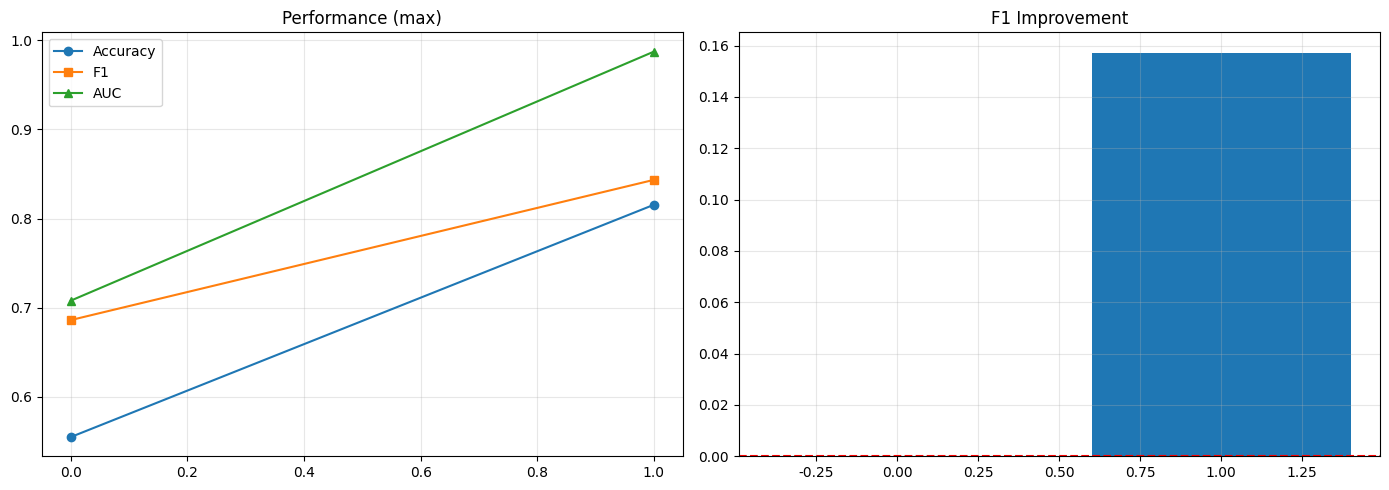

   iteration  accuracy        f1       auc   tn   fp  fn   tp
0          0    0.5550  0.686178  0.708005  137  863  27  973
1          1    0.8155  0.843445  0.987303  637  363   6  994


In [ ]:
history_df = pd.DataFrame(iteration_history)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_df['iteration'], history_df['accuracy'], marker='o', label='Accuracy')
axes[0].plot(history_df['iteration'], history_df['f1'], marker='s', label='F1')
axes[0].plot(history_df['iteration'], history_df['auc'], marker='^', label='AUC')
axes[0].set_title(f'Performance ({AGGREGATION})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

f1_delta = history_df['f1'] - history_df['f1'].iloc[0]
axes[1].bar(history_df['iteration'], f1_delta)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_title('F1 Improvement')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/performance_{AGGREGATION}.png', dpi=300)
plt.show()

print(history_df)

## 💾 저장

In [ ]:
history_df.to_csv(f'{RESULTS_DIR}/history_{AGGREGATION}.csv', index=False)

torch.save({
    'model_state_dict': model.state_dict(),
    'final_metrics': iteration_history[-1],
    'aggregation': AGGREGATION
}, f'{RESULTS_DIR}/final_model_{AGGREGATION}.pt')

summary = {
    'aggregation': AGGREGATION,
    'iterations': iteration_history,
    'improvement': {
        'f1_delta': float(history_df['f1'].iloc[-1] - history_df['f1'].iloc[0])
    }
}

with open(f'{RESULTS_DIR}/summary_{AGGREGATION}.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("✅ 저장 완료")

✅ 저장 완료


## 🎯 Test 예측

In [ ]:
df_test = pd.read_csv(TEST_DATA_PATH)

# 문단별 예측
print("🔮 문단별 예측...")
para_texts = df_test['paragraph_text'].tolist()
para_scores = predict_paragraph_scores(model, para_texts, tokenizer, device, BATCH_SIZE)

df_test['ai_score'] = para_scores
df_test['length'] = df_test['paragraph_text'].apply(len)

# 문서별 집계 (명시적으로!)
print("📊 문서별 집계...")
results = []
for doc_id in df_test['ID'].unique():
    doc_data = df_test[df_test['ID'] == doc_id]
    score = np.average(doc_data['ai_score'], weights=doc_data['length'])
    results.append({'ID': doc_id, 'generated': score})

submission = pd.DataFrame(results)

# ✅ 확인
print(submission.head(10).to_string(index=False))

submission.to_csv(f'{RESULTS_DIR}/submission.csv', index=False)
print(f"✅ 생성: {RESULTS_DIR}/submission.csv")

🔮 문단별 예측...
📊 문서별 집계...
       ID  generated
TEST_0000   0.246004
TEST_0001   0.380341
TEST_0002   0.177541
TEST_0003   0.510432
TEST_0004   0.562213
TEST_0005   0.938642
TEST_0006   0.912956
TEST_0007   0.742202
TEST_0008   0.626105
TEST_0009   0.369580
✅ 생성: /content/drive/MyDrive/멋사_프로젝트_01/paragraph_maxpool_results/submission.csv
